In [4]:
pip install torch

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install torchvision

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------ --------------------------------- 0.3/1.7 MB ? eta -:--:--
   ------------------ --------------------- 0.8/1.7 MB 1.3 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 1.5 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Custom Lightweight Blocks ---
class GhostModule(nn.Module):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_kernel_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = int(oup / ratio)
        new_channels = init_channels * (ratio - 1)

        self.primary_conv = nn.Sequential(
            nn.Conv2d(inp, init_channels, kernel_size, stride, kernel_size // 2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_kernel_size, 1, dw_kernel_size // 2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True) if relu else nn.Sequential()
        )

    def forward(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = torch.cat([x1, x2], dim=1)
        return out[:, :self.oup, :, :]

# --- Proposed CNN Architecture with SPD, MDC, ASPP, Ghost Block ---
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.atrous_block1 = nn.Conv2d(in_channels, out_channels, 1, padding=0, dilation=1)
        self.atrous_block6 = nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6)
        self.atrous_block12 = nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12)
        self.atrous_block18 = nn.Conv2d(in_channels, out_channels, 3, padding=18, dilation=18)
        self.conv_1x1_output = nn.Conv2d(out_channels * 4, out_channels, 1)

    def forward(self, x):
        x1 = self.atrous_block1(x)
        x2 = self.atrous_block6(x)
        x3 = self.atrous_block12(x)
        x4 = self.atrous_block18(x)
        x = torch.cat([x1, x2, x3, x4], dim=1)
        x = self.conv_1x1_output(x)
        return x

class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.spd = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.mdc = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=2, dilation=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=3, dilation=3),
            nn.ReLU()
        )
        self.aspp = ASPP(64, 64)
        self.ghost = GhostModule(64, 128)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(128, 4)

    def forward(self, x):
        x = self.initial(x)
        x = self.spd(x)
        x = self.mdc(x)
        x = self.aspp(x)
        x = self.ghost(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# --- Training Pipeline ---
data_dir = 'C:/Users/vivek/OneDrive - Amrita vishwa vidyapeetham/Documents/Blood cell Cancer [ALL]'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation Metrics
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=dataset.classes))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Epoch 1, Loss: 0.4686
Epoch 2, Loss: 0.2242
Epoch 3, Loss: 0.1261
Epoch 4, Loss: 0.1462
Epoch 5, Loss: 0.1194
Epoch 6, Loss: 0.0999
Epoch 7, Loss: 0.0787
Epoch 8, Loss: 0.0904
Epoch 9, Loss: 0.0732
Epoch 10, Loss: 0.1005
Classification Report:
                         precision    recall  f1-score   support

                 Benign       0.93      0.51      0.66       108
      [Malignant] Pre-B       0.43      1.00      0.60       179
      [Malignant] Pro-B       0.89      0.93      0.91       163
[Malignant] early Pre-B       0.00      0.00      0.00       199

               accuracy                           0.59       649
              macro avg       0.56      0.61      0.54       649
           weighted avg       0.50      0.59      0.50       649

Confusion Matrix:
[[ 55  44   9   0]
 [  0 179   0   0]
 [  2   9 152   0]
 [  2 188   9   0]]


c:\Users\vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\vivek\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Dataset path
dataset_path = 'C:/Users/vivek/OneDrive - Amrita vishwa vidyapeetham/Documents/Blood cell Cancer [ALL]'

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a Basic Convolution Block
def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Ghost Module (simplified)
class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GhostModule, self).__init__()
        self.primary_conv = conv_block(in_channels, out_channels // 2, 1, 1, 0)
        self.cheap_operation = conv_block(out_channels // 2, out_channels // 2, 3, 1, 1)

    def forward(self, x):
        primary = self.primary_conv(x)
        cheap = self.cheap_operation(primary)
        return torch.cat([primary, cheap], dim=1)

# SPD Block (Simplified Version)
class SPD(nn.Module):
    def __init__(self, in_channels):
        super(SPD, self).__init__()
        self.dw_conv = nn.Conv2d(in_channels, in_channels, 3, 1, 1, groups=in_channels)
        self.pw_conv = nn.Conv2d(in_channels, in_channels, 1)

    def forward(self, x):
        return F.relu(self.pw_conv(self.dw_conv(x)))

# MDC Block (Fixed padding to keep spatial size same)
class MDC(nn.Module):
    def __init__(self, in_channels):
        super(MDC, self).__init__()
        self.branch1 = conv_block(in_channels, in_channels, 3, padding=1)  # padding=1 for 3x3 conv
        self.branch2 = conv_block(in_channels, in_channels, 5, padding=2)  # padding=2 for 5x5 conv

    def forward(self, x):
        return F.relu(self.branch1(x) + self.branch2(x))

# Auxiliary Classifier
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels):
        super(AuxiliaryClassifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, 2)  # Binary classification

    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Full Model with Auxiliary Classifier
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()
        self.stem = conv_block(3, 32, 3)
        self.ghost1 = GhostModule(32, 64)
        self.spd = SPD(64)
        self.mdc = MDC(64)
        self.ghost2 = GhostModule(64, 128)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_main = nn.Linear(128, 4)  # 4-class classification
        self.aux_classifier = AuxiliaryClassifier(64)

    def forward(self, x):
        x = self.stem(x)
        x = self.ghost1(x)
        aux_out = self.aux_classifier(x)  # early features for binary
        x = self.spd(x)
        x = self.mdc(x)
        x = self.ghost2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        main_out = self.fc_main(x)
        return main_out, aux_out

# Evaluation metrics
def evaluate_model(preds, labels, average='macro'):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average=average, zero_division=0)
    rec = recall_score(labels, preds, average=average, zero_division=0)
    f1 = f1_score(labels, preds, average=average, zero_division=0)
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }

# Training and evaluation loop
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

        # Evaluate
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)
                all_preds.append(outputs)
                all_labels.append(labels)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        metrics = evaluate_model(all_preds, all_labels)
        print("Evaluation:", metrics)

# Run training
model = CancerClassifier()
train_model(model, train_loader, test_loader, epochs=10, lr=0.001)


Epoch 1/10, Loss: 0.4700
Evaluation: {'accuracy': 0.5808936825885979, 'precision': 0.7875858689131299, 'recall': 0.6333391817055801, 'f1_score': 0.5968512755117207}
Epoch 2/10, Loss: 0.2036
Evaluation: {'accuracy': 0.8073959938366718, 'precision': 0.8227534562211982, 'recall': 0.8299185996362745, 'f1_score': 0.8013809232496756}
Epoch 3/10, Loss: 0.1438
Evaluation: {'accuracy': 0.7426810477657936, 'precision': 0.7963696109379842, 'recall': 0.696445976794201, 'f1_score': 0.697817608322299}
Epoch 4/10, Loss: 0.1146
Evaluation: {'accuracy': 0.773497688751926, 'precision': 0.8441469703595464, 'recall': 0.7963556764021524, 'f1_score': 0.7738407829980862}
Epoch 5/10, Loss: 0.1080
Evaluation: {'accuracy': 0.9784283513097073, 'precision': 0.978219696969697, 'recall': 0.9799560698735228, 'f1_score': 0.9786366018677339}
Epoch 6/10, Loss: 0.0772
Evaluation: {'accuracy': 0.9861325115562404, 'precision': 0.9837344620534669, 'recall': 0.984213015757827, 'f1_score': 0.98395567641209}
Epoch 7/10, Loss:

In [9]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch 1/10, Loss: 0.4621
Evaluation: {'accuracy': 0.6841294298921418, 'precision': 0.580298013245033, 'recall': 0.6886980270042624, 'f1_score': 0.5885966056345977}
Epoch 2/10, Loss: 0.1922
Evaluation: {'accuracy': 0.8412942989214176, 'precision': 0.8497320494124946, 'recall': 0.8701076974381063, 'f1_score': 0.8307931901602535}
Epoch 3/10, Loss: 0.1407
Evaluation: {'accuracy': 0.7272727272727273, 'precision': 0.8724734042553192, 'recall': 0.6967979706047918, 'f1_score': 0.6474672485082249}
Epoch 4/10, Loss: 0.1073
Evaluation: {'accuracy': 0.9368258859784283, 'precision': 0.9563828233708634, 'recall': 0.8982289188474756, 'f1_score': 0.9143524389141942}
Epoch 5/10, Loss: 0.0915
Evaluation: {'accuracy': 0.9583975346687211, 'precision': 0.9597231004810792, 'recall': 0.9595211496058369, 'f1_score': 0.9581315500846088}
Epoch 6/10, Loss: 0.0940
Evaluation: {'accuracy': 0.9861325115562404, 'precision': 0.9795437405731524, 'recall': 0.986138304166855, 'f1_score': 0.9824836951739706}
Epoch 7/10, 

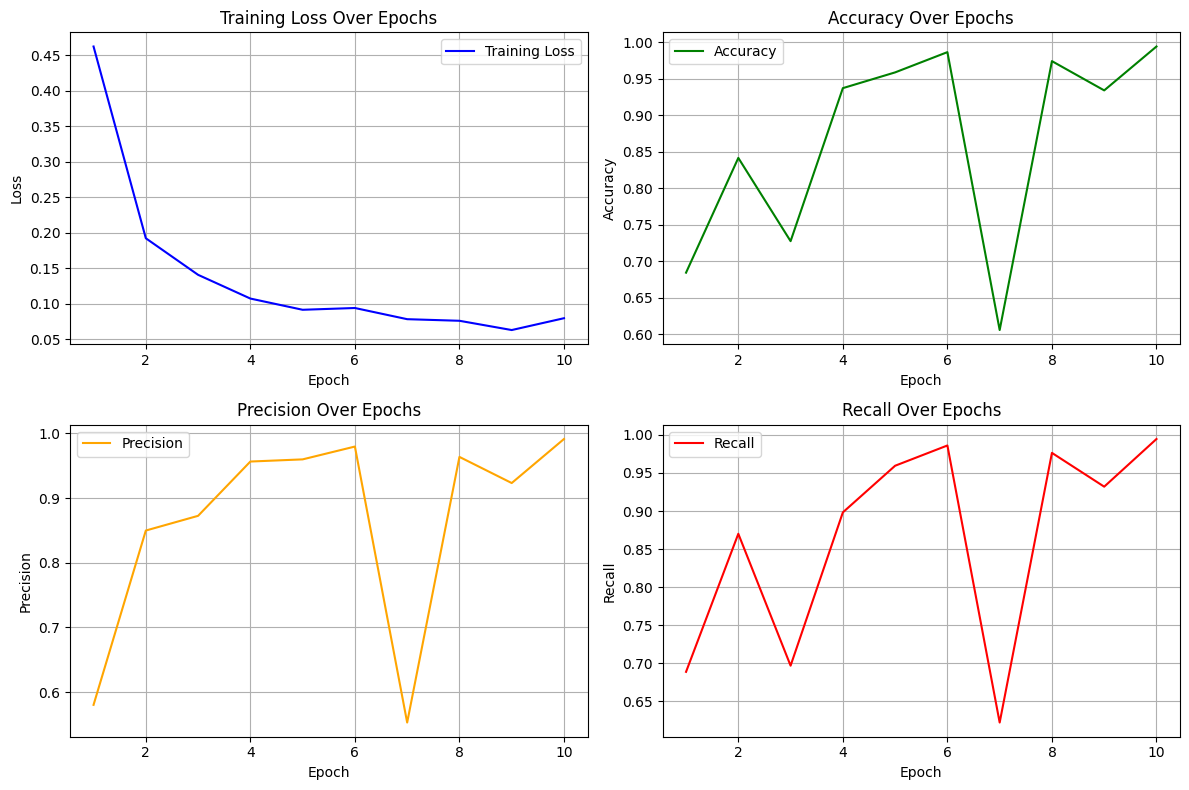


Classification Report:
                         precision    recall  f1-score   support

                 Benign       0.97      1.00      0.98        97
      [Malignant] Pre-B       0.99      0.99      0.99       193
      [Malignant] Pro-B       1.00      0.99      1.00       156
[Malignant] early Pre-B       1.00      0.99      1.00       203

               accuracy                           0.99       649
              macro avg       0.99      0.99      0.99       649
           weighted avg       0.99      0.99      0.99       649



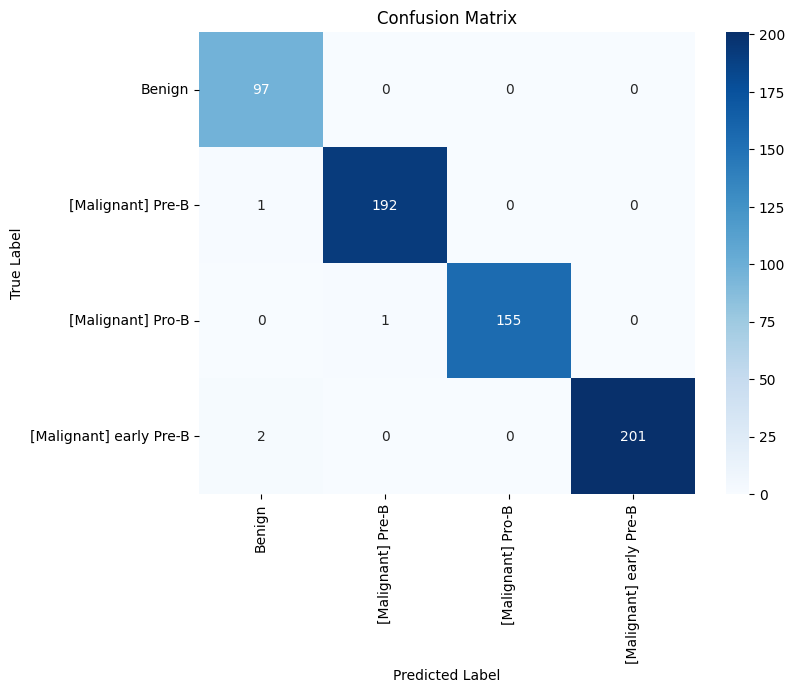

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# Dataset path
dataset_path = 'C:/Users/vivek/OneDrive - Amrita vishwa vidyapeetham/Documents/Blood cell Cancer [ALL]'

# Define transforms
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a Basic Convolution Block
def conv_block(in_channels, out_channels, kernel_size, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

# Ghost Module (simplified)
class GhostModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GhostModule, self).__init__()
        self.primary_conv = conv_block(in_channels, out_channels // 2, 1, 1, 0)
        self.cheap_operation = conv_block(out_channels // 2, out_channels // 2, 3, 1, 1)

    def forward(self, x):
        primary = self.primary_conv(x)
        cheap = self.cheap_operation(primary)
        return torch.cat([primary, cheap], dim=1)

# SPD Block (Simplified Version)
class SPD(nn.Module):
    def __init__(self, in_channels):
        super(SPD, self).__init__()
        self.dw_conv = nn.Conv2d(in_channels, in_channels, 3, 1, 1, groups=in_channels)
        self.pw_conv = nn.Conv2d(in_channels, in_channels, 1)

    def forward(self, x):
        return F.relu(self.pw_conv(self.dw_conv(x)))

# MDC Block (Fixed padding to keep spatial size same)
class MDC(nn.Module):
    def __init__(self, in_channels):
        super(MDC, self).__init__()
        self.branch1 = conv_block(in_channels, in_channels, 3, padding=1)  # padding=1 for 3x3 conv
        self.branch2 = conv_block(in_channels, in_channels, 5, padding=2)  # padding=2 for 5x5 conv

    def forward(self, x):
        return F.relu(self.branch1(x) + self.branch2(x))

# Auxiliary Classifier
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels):
        super(AuxiliaryClassifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(in_channels, 2)  # Binary classification

    def forward(self, x):
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Full Model with Auxiliary Classifier
class CancerClassifier(nn.Module):
    def __init__(self):
        super(CancerClassifier, self).__init__()
        self.stem = conv_block(3, 32, 3)
        self.ghost1 = GhostModule(32, 64)
        self.spd = SPD(64)
        self.mdc = MDC(64)
        self.ghost2 = GhostModule(64, 128)

        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc_main = nn.Linear(128, 4)  # 4-class classification
        self.aux_classifier = AuxiliaryClassifier(64)

    def forward(self, x):
        x = self.stem(x)
        x = self.ghost1(x)
        aux_out = self.aux_classifier(x)  # early features for binary
        x = self.spd(x)
        x = self.mdc(x)
        x = self.ghost2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        main_out = self.fc_main(x)
        return main_out, aux_out

# Evaluation metrics
def evaluate_model(preds, labels, average='macro'):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average=average, zero_division=0)
    rec = recall_score(labels, preds, average=average, zero_division=0)
    f1 = f1_score(labels, preds, average=average, zero_division=0)
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1
    }

# Training and evaluation loop with plotting
train_losses = []
eval_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, aux_outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        # Evaluate
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)
                all_preds.append(outputs)
                all_labels.append(labels)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        metrics = evaluate_model(all_preds, all_labels)
        print("Evaluation:", metrics)

        # Store metrics
        eval_metrics['accuracy'].append(metrics['accuracy'])
        eval_metrics['precision'].append(metrics['precision'])
        eval_metrics['recall'].append(metrics['recall'])
        eval_metrics['f1_score'].append(metrics['f1_score'])

    # Plotting results after training
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(12, 8))

    # Training Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, eval_metrics['accuracy'], label='Accuracy', color='green')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    # Precision
    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, eval_metrics['precision'], label='Precision', color='orange')
    plt.title('Precision Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.grid()
    plt.legend()

    # Recall
    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, eval_metrics['recall'], label='Recall', color='red')
    plt.title('Recall Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run training
model = CancerClassifier()
train_model(model, train_loader, test_loader, epochs=10, lr=0.001)



def test_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    model.to(device)

    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=full_dataset.classes,
                yticklabels=full_dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Run the final test
test_model(model, test_loader)
